## Live Project 

### Objective 
Sales director of the company is tasked with developing key sales statistical and analytical insights to grow the company to make informed business decisions. These analyses serves as evaluating agent performance, revenue, expenses and probability. These insights will help them to steer the agency towards sustained growth and success in dynamic entertainment landscape.


## Establishing SQL connection to Machine Learning

In [1]:
import pandas as pd
from sqlalchemy import create_engine # Takes in the connection URL and returns SQLALchemy Engine
import urllib #Handling URLs, parsing them and sending HTTP request

# DB credentials
server = 'qaececrm-s1.database.windows.net'  
database = 'QAECECRM_June2025'
username = 'dbadmin'
password = 'DashTech1234'
driver = 'ODBC Driver 17 for SQL Server'

# Create connection string
params = urllib.parse.quote_plus(
    f"DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}"
)

engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

### Collecting and Generating the Tables From the Database

In [2]:
from sqlalchemy import text #to run raw SQL queries

def get_all_table(engine):
    with engine.connect() as conn:
        result = conn.execute(text("""SELECT t.name as table_name
                                  FROM sys.tables t
                                  ORDER BY t.name"""))
        table_list = [row[0] for row in result]
        table_df = pd.DataFrame(table_list, columns=['Name of the tables'])
    return table_df    


table_df = get_all_table(engine)
#table_list = table_df['Name of the tables'].tolist()
#print(table_list)
#Count of the tables
print(f"Total number of tables presented: {len(table_df)}")

table_df

Total number of tables presented: 189


,Name of the tables
0,AgentCommission
1,AgentCommissionProgram
2,AgentCommissionTypeData
3,AgentPayrollLog
4,Alert
...,...
184,VenueDescription
185,VenueGenreType
186,VenueRequirement
187,VenueRequirementNotification


In [3]:
def load_table(engine, table_name):
    with engine.connect() as conn:
        query = text(f"SELECT * FROM {table_name}")
        df = pd.read_sql(query, conn) #Read SQL database 
    return df

##### To build a classification model that predicts whether a contract will be finalized (signed) or not based on offer, agent, artist, and venue-related features.

In [4]:
table_name = "Contract" #Mention the table name that we want to mention
df = load_table(engine, table_name)

In [5]:
df.head()

,ContractId,AgentId,OfficeId,ContractStatusId,LineOfBusinessId,Gross,BlueCardId,LeadSourceId,ContractTypeId,IsReseller,...,CreatedDate,CreatedById,UpdatedDate,UpdatedById,ArchiveDate,OriginalGross,IsProblemExcluded,EventDescription,IsWillAgentAttendTheEvent,IsSalaried
0,100304,0,17.0,3,2.0,1700.0,NaN,3.0,1.0,True,...,1988-09-15,0,2018-06-19 07:31:43.930,999999.0,2018-06-02,NaN,False,None,False,False
1,101731,419,1.0,6,3.0,550.0,NaN,5.0,1.0,True,...,1989-01-03,0,2018-06-19 07:31:43.930,999999.0,2018-06-02,NaN,False,None,False,False
2,103324,0,1.0,4,3.0,2000.0,NaN,5.0,1.0,False,...,2001-04-28,0,2018-06-02 17:22:01.970,999999.0,2018-06-02,NaN,False,None,False,False
3,103331,313,1.0,5,3.0,1500.0,NaN,5.0,1.0,True,...,1989-04-28,0,2018-06-19 07:31:43.930,999999.0,2018-06-02,NaN,False,None,False,False
4,103526,0,1.0,3,3.0,1000.0,NaN,5.0,1.0,False,...,1989-05-15,0,2018-06-02 17:22:01.970,999999.0,2018-06-02,NaN,False,None,False,False


In [6]:
df.shape

(303633, 70)

In [7]:
columns_to_select = ['Gross', 'AgentId', 'OfficeId', 'LineOfBusinessId', 'LeadSourceId', 'ContractTypeId',
    'IsReseller', 'IsBuySell', 'IsBackendDeal', 'EventTypeId', 'TimezoneId', 'IsPublicEvent',
    'VenueId', 'VenueCapacity', 'VenueSettingId', 'IsSettingCovered', 'ECECommissionRate',
    'IsCommissionPercentage', 'HasIssues', 'IsNoIssue', 'IsWillAgentAttendTheEvent', 'IsSalaried',
    'CreatedDate', 'ContractDueDate', 'IssueDate', 'CancellationDate',
    'PresenterTypeId', 'PresenterMailingStateId', 'VenuePhysicalStateId']
df_contract = df[columns_to_select]

#### Target Variable

In [8]:
status_mapping = {
    1: 0,  # Draft / Pending
    2: 0,  # In Progress
    3: 1,  # Finalized / Signed
    4: 0,  # Cancelled
    5: 0,  # Withdrawn
    6: 1,  # Approved / Signed
    7: 0   # Rejected
}

# Create the new binary target column
df_contract['IsFinalized'] = df['ContractStatusId'].map(status_mapping)

/tmp/ipykernel_2964/3106077432.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contract['IsFinalized'] = df['ContractStatusId'].map(status_mapping)


In [9]:
df_contract.head()

,Gross,AgentId,OfficeId,LineOfBusinessId,LeadSourceId,ContractTypeId,IsReseller,IsBuySell,IsBackendDeal,EventTypeId,...,IsWillAgentAttendTheEvent,IsSalaried,CreatedDate,ContractDueDate,IssueDate,CancellationDate,PresenterTypeId,PresenterMailingStateId,VenuePhysicalStateId,IsFinalized
0,1700.0,0,17.0,2.0,3.0,1.0,True,True,False,8.0,...,False,False,1988-09-15,2001-11-17,1988-09-15,NaT,20.0,46.0,46.0,1
1,550.0,419,1.0,3.0,5.0,1.0,True,False,False,8.0,...,False,False,1989-01-03,1989-02-10,1989-01-03,1991-03-14,20.0,46.0,46.0,1
2,2000.0,0,1.0,3.0,5.0,1.0,False,False,False,8.0,...,False,False,2001-04-28,1989-05-05,2001-04-28,NaT,20.0,46.0,46.0,0
3,1500.0,313,1.0,3.0,5.0,1.0,True,False,False,19.0,...,False,False,1989-04-28,1989-05-13,1989-04-28,NaT,49.0,46.0,46.0,0
4,1000.0,0,1.0,3.0,5.0,1.0,False,False,False,26.0,...,False,False,1989-05-15,1990-10-30,1989-05-15,NaT,99.0,46.0,46.0,1


In [10]:
df_contract.shape

(303633, 30)

In [11]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303633 entries, 0 to 303632
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Gross                      303633 non-null  float64       
 1   AgentId                    303633 non-null  int64         
 2   OfficeId                   301890 non-null  float64       
 3   LineOfBusinessId           301890 non-null  float64       
 4   LeadSourceId               301890 non-null  float64       
 5   ContractTypeId             301890 non-null  float64       
 6   IsReseller                 301890 non-null  object        
 7   IsBuySell                  301890 non-null  object        
 8   IsBackendDeal              301890 non-null  object        
 9   EventTypeId                302828 non-null  float64       
 10  TimezoneId                 36771 non-null   float64       
 11  IsPublicEvent              302827 non-null  object  

In [12]:
df_contract.isnull().sum()

Gross                             0
AgentId                           0
OfficeId                       1743
LineOfBusinessId               1743
LeadSourceId                   1743
ContractTypeId                 1743
IsReseller                     1743
IsBuySell                      1743
IsBackendDeal                  1743
EventTypeId                     805
TimezoneId                   266862
IsPublicEvent                   806
VenueId                      285000
VenueCapacity                299933
VenueSettingId                 1573
IsSettingCovered               1007
ECECommissionRate            268011
IsCommissionPercentage         2441
HasIssues                         0
IsNoIssue                      1743
IsWillAgentAttendTheEvent       308
IsSalaried                       41
CreatedDate                       0
ContractDueDate                1889
IssueDate                      6785
CancellationDate             259129
PresenterTypeId                1485
PresenterMailingStateId     

In [13]:
null_info = df_contract.isnull().sum()
null_columns = null_info[null_info > 0]

null_val = pd.DataFrame({
    'Data Type': df_contract[null_columns.index].dtypes,
    'Null Count': null_columns
})

null_val

,Data Type,Null Count
OfficeId,float64,1743
LineOfBusinessId,float64,1743
LeadSourceId,float64,1743
ContractTypeId,float64,1743
IsReseller,object,1743
IsBuySell,object,1743
IsBackendDeal,object,1743
EventTypeId,float64,805
TimezoneId,float64,266862
IsPublicEvent,object,806


In [14]:
#Filling null values for numerical and categorical columns
for col in df_contract.columns:
    if df_contract[col].isnull().sum() > 0:
        if df_contract[col].dtype == 'float64' or df_contract[col].dtype == 'int64':
            df_contract[col].fillna(df_contract[col].median(), inplace=True) # median
        elif df_contract[col].dtype == 'object':
            df_contract[col].fillna(df_contract[col].mode()[0], inplace=True) # Mode

/tmp/ipykernel_2964/2244650036.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contract[col].fillna(df_contract[col].median(), inplace=True) # median
/tmp/ipykernel_2964/2244650036.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contract[col].fillna(df_contract[col].median(), inplace=True) # median
/tmp/ipykernel_2964/2244650036.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contract[col].fillna(df_contract[col].m

In [15]:
date_cols = ['CreatedDate', 'ContractDueDate', 'IssueDate', 'CancellationDate']
for col in date_cols:
    df_contract[col] = pd.to_datetime(df_contract[col], errors='coerce')
    df_contract[col] = df_contract[col].fillna(pd.Timestamp('2000-01-01'))

/tmp/ipykernel_2964/1485168044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contract[col] = pd.to_datetime(df_contract[col], errors='coerce')
/tmp/ipykernel_2964/1485168044.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contract[col] = df_contract[col].fillna(pd.Timestamp('2000-01-01'))
/tmp/ipykernel_2964/1485168044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [16]:
df_contract.isnull().sum()

Gross                        0
AgentId                      0
OfficeId                     0
LineOfBusinessId             0
LeadSourceId                 0
ContractTypeId               0
IsReseller                   0
IsBuySell                    0
IsBackendDeal                0
EventTypeId                  0
TimezoneId                   0
IsPublicEvent                0
VenueId                      0
VenueCapacity                0
VenueSettingId               0
IsSettingCovered             0
ECECommissionRate            0
IsCommissionPercentage       0
HasIssues                    0
IsNoIssue                    0
IsWillAgentAttendTheEvent    0
IsSalaried                   0
CreatedDate                  0
ContractDueDate              0
IssueDate                    0
CancellationDate             0
PresenterTypeId              0
PresenterMailingStateId      0
VenuePhysicalStateId         0
IsFinalized                  0
dtype: int64

In [17]:
pd.set_option('display.max_columns', None)
df_contract.head()

,Gross,AgentId,OfficeId,LineOfBusinessId,LeadSourceId,ContractTypeId,IsReseller,IsBuySell,IsBackendDeal,EventTypeId,TimezoneId,IsPublicEvent,VenueId,VenueCapacity,VenueSettingId,IsSettingCovered,ECECommissionRate,IsCommissionPercentage,HasIssues,IsNoIssue,IsWillAgentAttendTheEvent,IsSalaried,CreatedDate,ContractDueDate,IssueDate,CancellationDate,PresenterTypeId,PresenterMailingStateId,VenuePhysicalStateId,IsFinalized
0,1700.0,0,17.0,2.0,3.0,1.0,True,True,False,8.0,1.0,False,671.0,300.0,1.0,True,20.0,True,False,True,False,False,1988-09-15,2001-11-17,1988-09-15,2000-01-01,20.0,46.0,46.0,1
1,550.0,419,1.0,3.0,5.0,1.0,True,False,False,8.0,1.0,False,671.0,300.0,1.0,True,20.0,True,False,True,False,False,1989-01-03,1989-02-10,1989-01-03,1991-03-14,20.0,46.0,46.0,1
2,2000.0,0,1.0,3.0,5.0,1.0,False,False,False,8.0,1.0,False,671.0,300.0,1.0,True,20.0,True,False,False,False,False,2001-04-28,1989-05-05,2001-04-28,2000-01-01,20.0,46.0,46.0,0
3,1500.0,313,1.0,3.0,5.0,1.0,True,False,False,19.0,1.0,False,671.0,300.0,1.0,True,20.0,True,False,True,False,False,1989-04-28,1989-05-13,1989-04-28,2000-01-01,49.0,46.0,46.0,0
4,1000.0,0,1.0,3.0,5.0,1.0,False,False,False,26.0,1.0,False,671.0,300.0,1.0,True,20.0,True,False,False,False,False,1989-05-15,1990-10-30,1989-05-15,2000-01-01,99.0,46.0,46.0,1


## Feature Encoding

In [18]:
bool_cols = df_contract.select_dtypes(include='bool').columns
df_contract[bool_cols] = df_contract[bool_cols].astype(int)

/tmp/ipykernel_2964/3314182306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contract[bool_cols] = df_contract[bool_cols].astype(int)


In [19]:
df_contract.head()

,Gross,AgentId,OfficeId,LineOfBusinessId,LeadSourceId,ContractTypeId,IsReseller,IsBuySell,IsBackendDeal,EventTypeId,TimezoneId,IsPublicEvent,VenueId,VenueCapacity,VenueSettingId,IsSettingCovered,ECECommissionRate,IsCommissionPercentage,HasIssues,IsNoIssue,IsWillAgentAttendTheEvent,IsSalaried,CreatedDate,ContractDueDate,IssueDate,CancellationDate,PresenterTypeId,PresenterMailingStateId,VenuePhysicalStateId,IsFinalized
0,1700.0,0,17.0,2.0,3.0,1.0,1,1,0,8.0,1.0,0,671.0,300.0,1.0,1,20.0,1,0,1,0,0,1988-09-15,2001-11-17,1988-09-15,2000-01-01,20.0,46.0,46.0,1
1,550.0,419,1.0,3.0,5.0,1.0,1,0,0,8.0,1.0,0,671.0,300.0,1.0,1,20.0,1,0,1,0,0,1989-01-03,1989-02-10,1989-01-03,1991-03-14,20.0,46.0,46.0,1
2,2000.0,0,1.0,3.0,5.0,1.0,0,0,0,8.0,1.0,0,671.0,300.0,1.0,1,20.0,1,0,0,0,0,2001-04-28,1989-05-05,2001-04-28,2000-01-01,20.0,46.0,46.0,0
3,1500.0,313,1.0,3.0,5.0,1.0,1,0,0,19.0,1.0,0,671.0,300.0,1.0,1,20.0,1,0,1,0,0,1989-04-28,1989-05-13,1989-04-28,2000-01-01,49.0,46.0,46.0,0
4,1000.0,0,1.0,3.0,5.0,1.0,0,0,0,26.0,1.0,0,671.0,300.0,1.0,1,20.0,1,0,0,0,0,1989-05-15,1990-10-30,1989-05-15,2000-01-01,99.0,46.0,46.0,1


In [20]:
#Dropping date columns
df_contract = df_contract.drop(columns=['CreatedDate','ContractDueDate','IssueDate','CancellationDate'],axis=1)

In [21]:
df_contract.head()

,Gross,AgentId,OfficeId,LineOfBusinessId,LeadSourceId,ContractTypeId,IsReseller,IsBuySell,IsBackendDeal,EventTypeId,TimezoneId,IsPublicEvent,VenueId,VenueCapacity,VenueSettingId,IsSettingCovered,ECECommissionRate,IsCommissionPercentage,HasIssues,IsNoIssue,IsWillAgentAttendTheEvent,IsSalaried,PresenterTypeId,PresenterMailingStateId,VenuePhysicalStateId,IsFinalized
0,1700.0,0,17.0,2.0,3.0,1.0,1,1,0,8.0,1.0,0,671.0,300.0,1.0,1,20.0,1,0,1,0,0,20.0,46.0,46.0,1
1,550.0,419,1.0,3.0,5.0,1.0,1,0,0,8.0,1.0,0,671.0,300.0,1.0,1,20.0,1,0,1,0,0,20.0,46.0,46.0,1
2,2000.0,0,1.0,3.0,5.0,1.0,0,0,0,8.0,1.0,0,671.0,300.0,1.0,1,20.0,1,0,0,0,0,20.0,46.0,46.0,0
3,1500.0,313,1.0,3.0,5.0,1.0,1,0,0,19.0,1.0,0,671.0,300.0,1.0,1,20.0,1,0,1,0,0,49.0,46.0,46.0,0
4,1000.0,0,1.0,3.0,5.0,1.0,0,0,0,26.0,1.0,0,671.0,300.0,1.0,1,20.0,1,0,0,0,0,99.0,46.0,46.0,1


## Model Building

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [26]:
X = df_contract.drop(columns=['IsFinalized'])
y = df_contract['IsFinalized']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [43]:
rf = RandomForestClassifier(n_estimators=600, random_state=42, criterion='gini')
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=600, random_state=42)

In [44]:
# Predict class labels
y_pred = rf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
percentage = round(accuracy * 100, 2)  
print(f"Accuracy: {percentage}%")


Accuracy: 69.64%


In [45]:
# Full classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.82      0.77     38698
           1       0.60      0.49      0.54     22029

    accuracy                           0.70     60727
   macro avg       0.67      0.65      0.66     60727
weighted avg       0.69      0.70      0.69     60727



In [46]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[31540  7158]
 [11279 10750]]


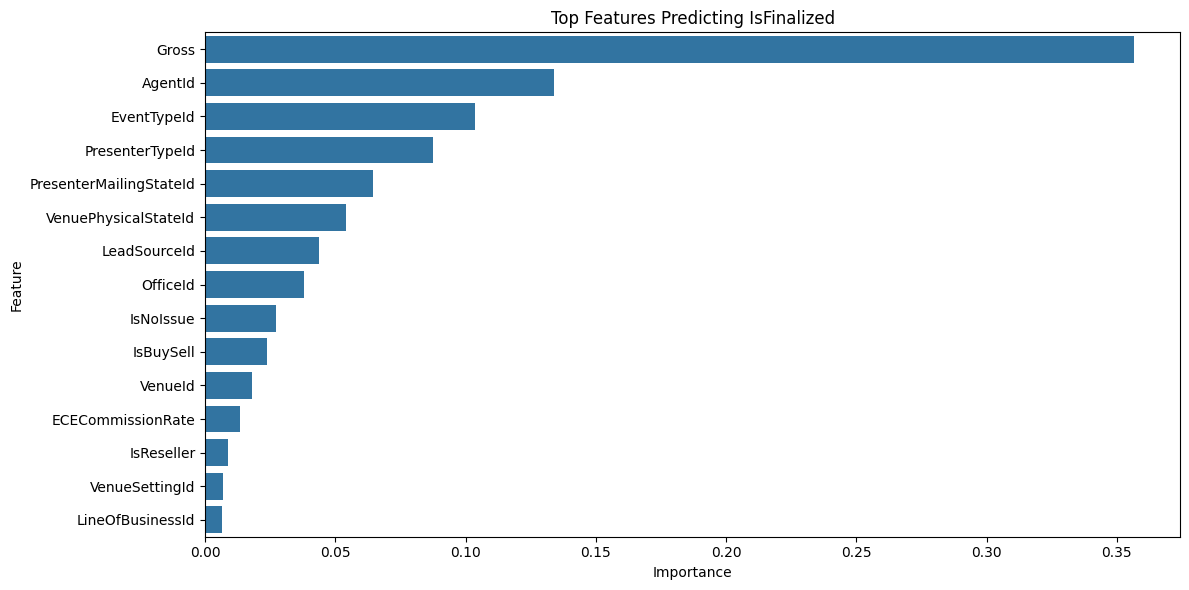

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = rf.feature_importances_
features = X.columns

# Create DataFrame
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
plt.title('Top Features Predicting IsFinalized')
plt.tight_layout()
plt.show()